In [1]:
import os
import cv2
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

from Models import HomographyRegressor, HomographyClassifier
from Models import classes_to_offsets, visualize_regression_result, visualize_classification_result
from Generator import generate_pair, get_random_images

In [2]:
# ============================================================
# Prepare Dataset
# ============================================================

from Generator import prepair_dataset

INPUT_DIR = "datasets/val2017"
PREPROCESSED_DIR = "datasets/val2017_preprocessed"

TARGET_SIZE = (320, 240)
prepair_dataset(INPUT_DIR, PREPROCESSED_DIR, TARGET_SIZE)


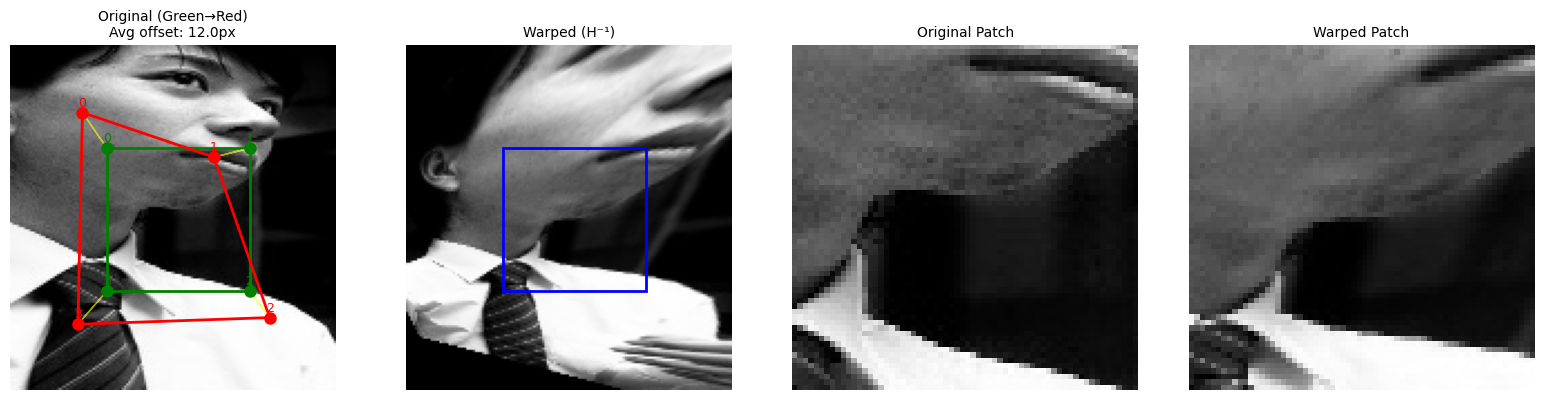

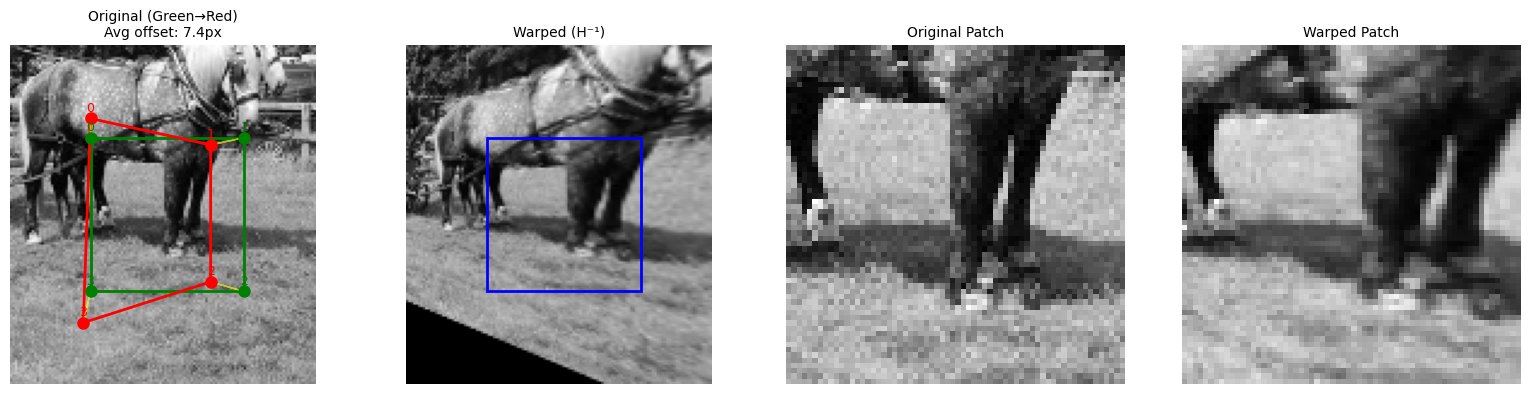

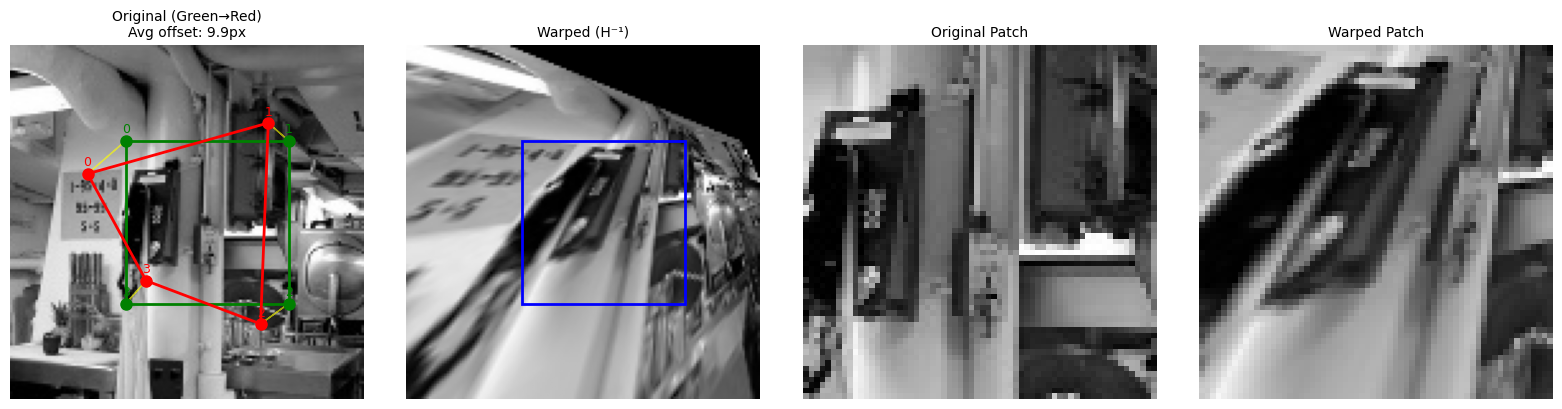

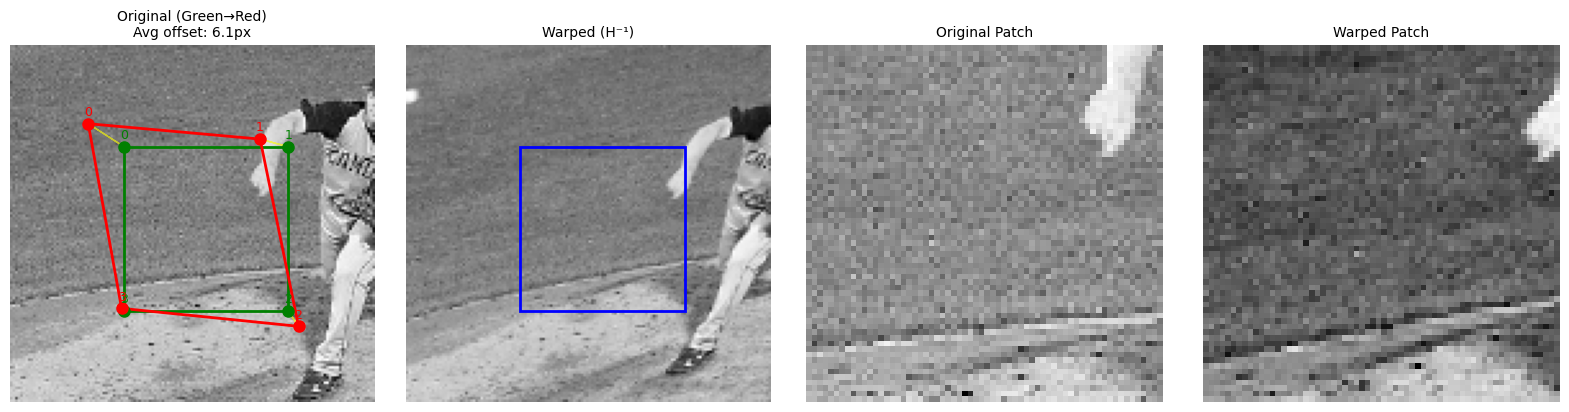

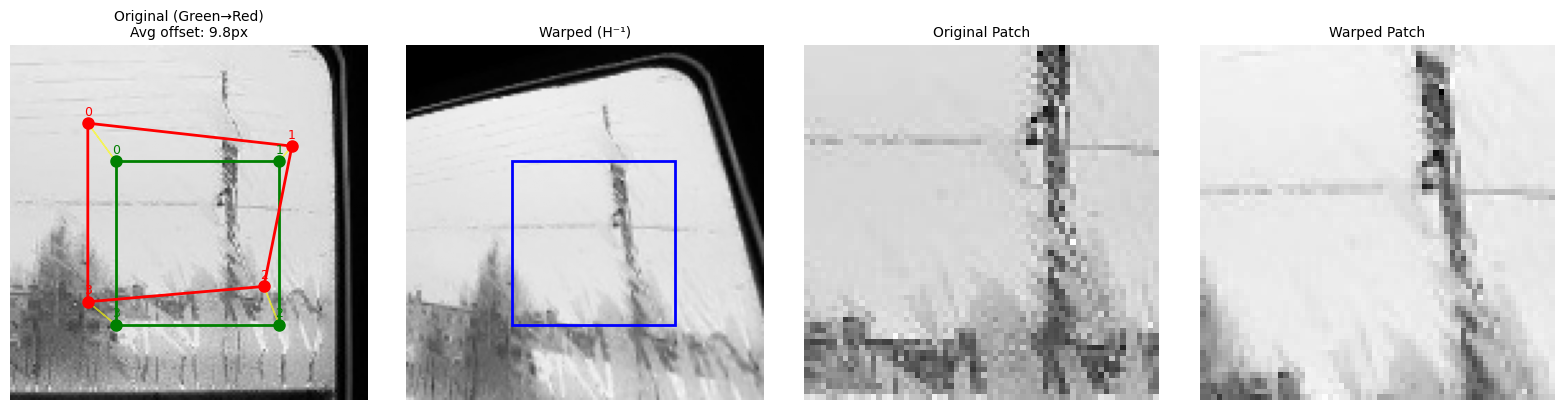

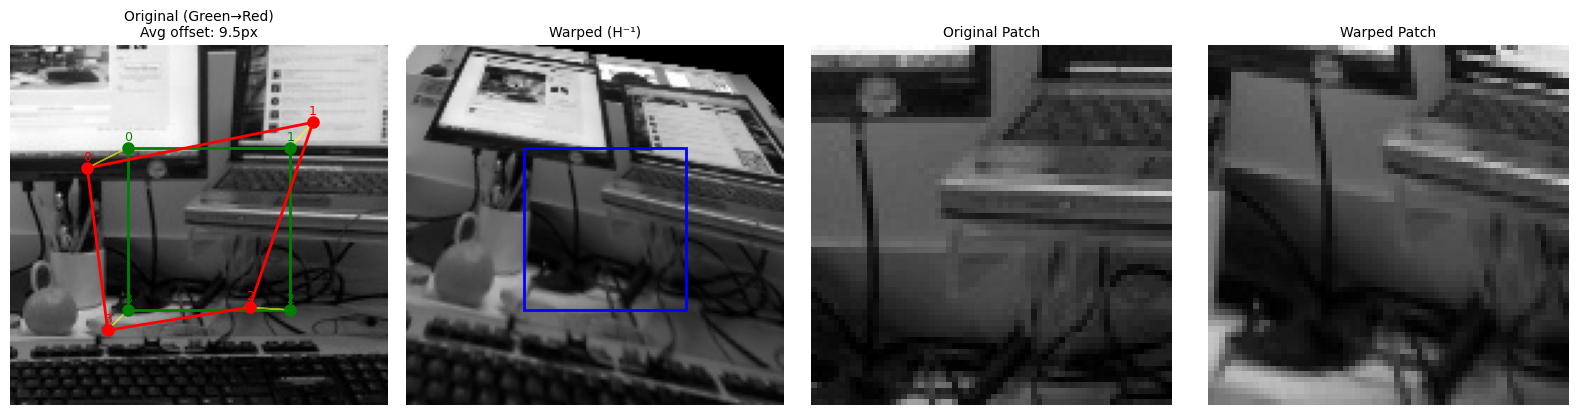

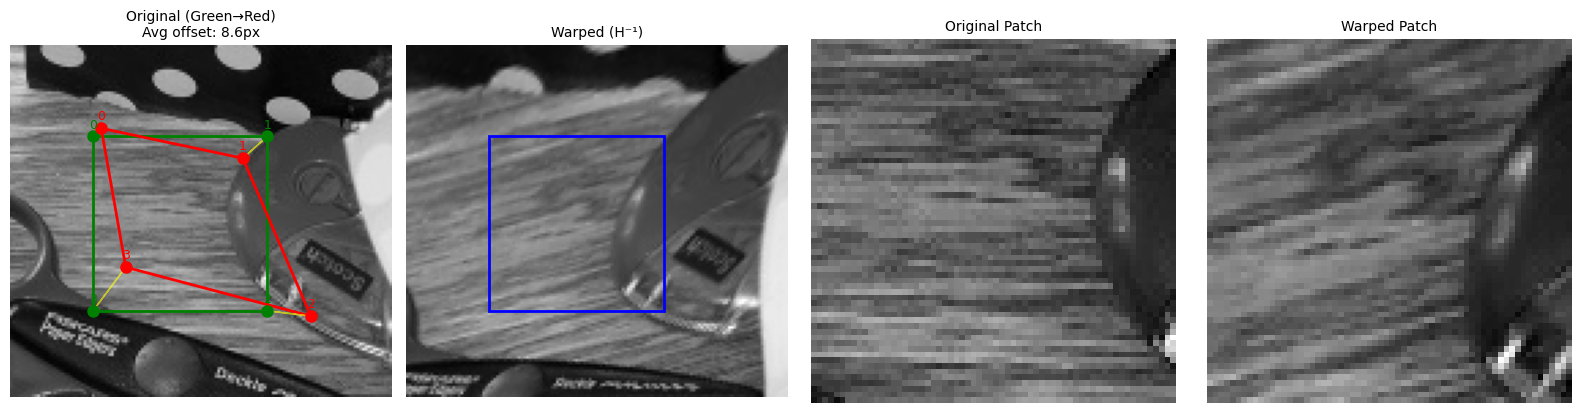

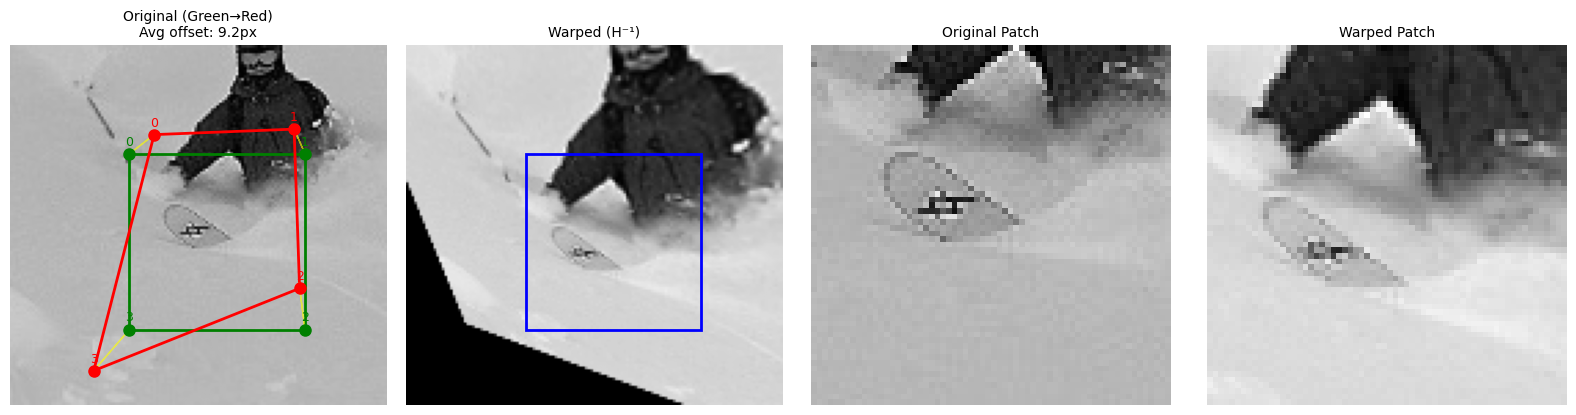

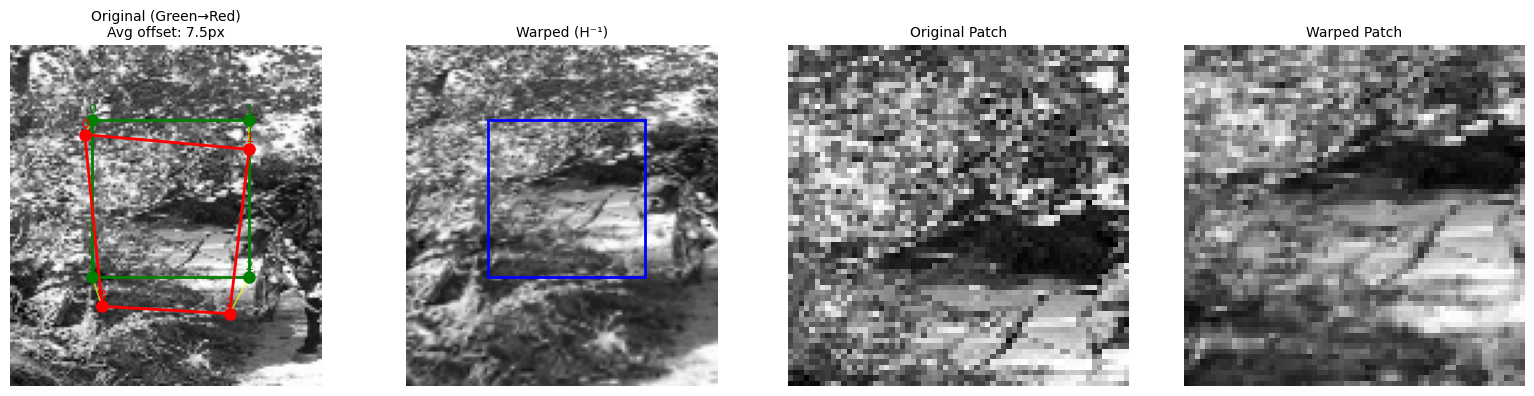

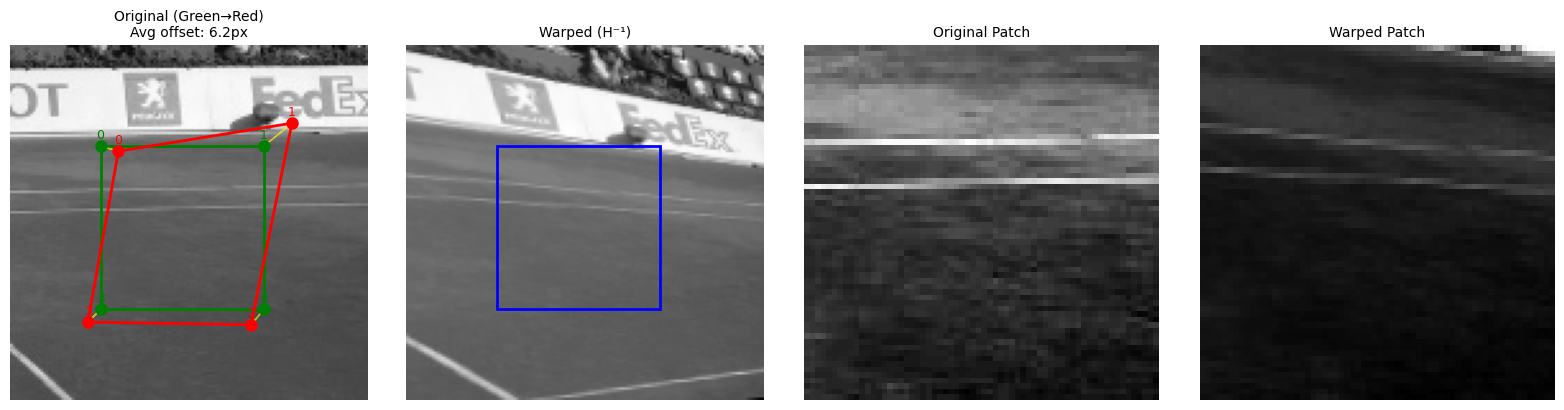

In [9]:
from Generator import visualize_generate_pair

# Run visualization
for _ in range(10):
    visualize_generate_pair(PREPROCESSED_DIR)

In [14]:
from torchinfo import summary
from Models import ResNetBlock

# For ResNet block
block = ResNetBlock(in_channels=64, out_channels=128, stride=2, dropout_rate=0.1)
summary(block, input_size=(1, 64, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetBlock                              [1, 128, 16, 16]          --
├─Conv2d: 1-1                            [1, 128, 16, 16]          8,320
├─Conv2d: 1-2                            [1, 128, 16, 16]          73,856
├─Dropout2d: 1-3                         [1, 128, 16, 16]          --
├─ReLU: 1-4                              [1, 128, 16, 16]          --
├─Conv2d: 1-5                            [1, 128, 16, 16]          147,584
├─Dropout2d: 1-6                         [1, 128, 16, 16]          --
├─ReLU: 1-7                              [1, 128, 16, 16]          --
Total params: 229,760
Trainable params: 229,760
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 58.82
Input size (MB): 0.26
Forward/backward pass size (MB): 0.79
Params size (MB): 0.92
Estimated Total Size (MB): 1.97

In [17]:
from torchinfo import summary
from Models import ResNetBody

# For ResNet body
body = ResNetBody(in_channels=2, dropout_rate=0.1)
summary(body, input_size=(1, 2, 64, 64),depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
ResNetBody                               [1, 512]                  --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─ResNetBlock: 2-1                  [1, 64, 64, 64]           38,336
│    └─ResNetBlock: 2-2                  [1, 64, 64, 64]           73,856
│    └─BatchNorm2d: 2-3                  [1, 64, 64, 64]           128
│    └─ReLU: 2-4                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 64, 16, 16]           --
│    └─ResNetBlock: 2-6                  [1, 64, 32, 32]           73,856
│    └─ResNetBlock: 2-7                  [1, 64, 32, 32]           73,856
│    └─BatchNorm2d: 2-8                  [1, 64, 32, 32]           128
│    └─ReLU: 2-9                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 64, 16, 16]           

In [18]:
from torchinfo import summary

# For regression model
model = HomographyRegressor()
summary(model, input_size=(1, 2, 64, 64), depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
HomographyRegressor                      [1, 8]                    --
├─ResNetBody: 1-1                        [1, 512]                  --
│    └─Sequential: 2-1                   [1, 64, 32, 32]           112,320
│    └─Sequential: 2-2                   [1, 64, 16, 16]           147,840
│    └─Sequential: 2-3                   [1, 128, 8, 8]            525,184
│    └─Sequential: 2-4                   [1, 128, 8, 8]            590,592
│    └─Flatten: 2-5                      [1, 8192]                 --
│    └─Linear: 2-6                       [1, 512]                  4,194,816
├─RegressionHead: 1-2                    [1, 8]                    --
│    └─Linear: 2-7                       [1, 8]                    4,104
Total params: 5,574,856
Trainable params: 5,574,856
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 787.16
Input size (MB): 0.03
Forward/backward pass size (MB): 17.11
Params size (MB)

In [19]:
from torchinfo import summary

# For classification model
model = HomographyClassifier(num_classes=21, class_dim=8)
summary(model, input_size=(1, 2, 64, 64), depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
HomographyClassifier                     [1, 8, 21]                --
├─ResNetBody: 1-1                        [1, 512]                  --
│    └─Sequential: 2-1                   [1, 64, 32, 32]           112,320
│    └─Sequential: 2-2                   [1, 64, 16, 16]           147,840
│    └─Sequential: 2-3                   [1, 128, 8, 8]            525,184
│    └─Sequential: 2-4                   [1, 128, 8, 8]            590,592
│    └─Flatten: 2-5                      [1, 8192]                 --
│    └─Linear: 2-6                       [1, 512]                  4,194,816
├─ClassificationHead: 1-2                [1, 8, 21]                --
│    └─Linear: 2-7                       [1, 168]                  86,184
Total params: 5,656,936
Trainable params: 5,656,936
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 787.24
Input size (MB): 0.03
Forward/backward pass size (MB): 17.11
Params size (MB

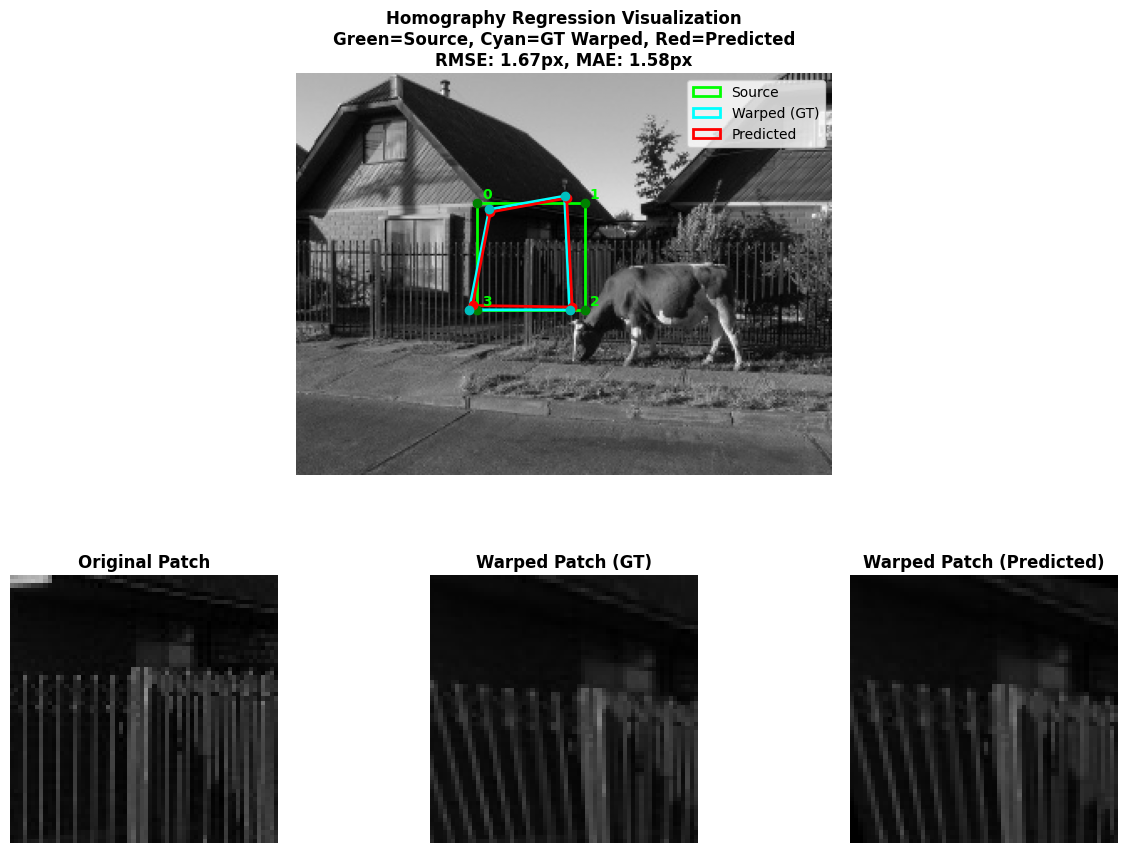

Ground Truth Offsets:
 [[  7.   4.]
 [-12.  -4.]
 [ -9.   0.]
 [ -5.   0.]]
Predicted Offsets:
 [[  7.75   5.58]
 [-10.73  -2.77]
 [ -7.46  -1.68]
 [ -2.98  -2.61]]
Mean abs error per corner: [1.394 1.775]


In [27]:
# visualization of regression results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyRegressor().to(device)
# state = torch.load("checkpoints_homography_regressor_single/checkpoint_epoch_30000.pth")["model_state_dict"]
state = torch.load("Models/Regressor/checkpoints_homography_regressor_all/h_regressor_all.pth")
model.load_state_dict(state)
model.eval()

# img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
img = get_random_images(1, image_dir=PREPROCESSED_DIR)[0]
visualize_regression_result(model=model, image=img)

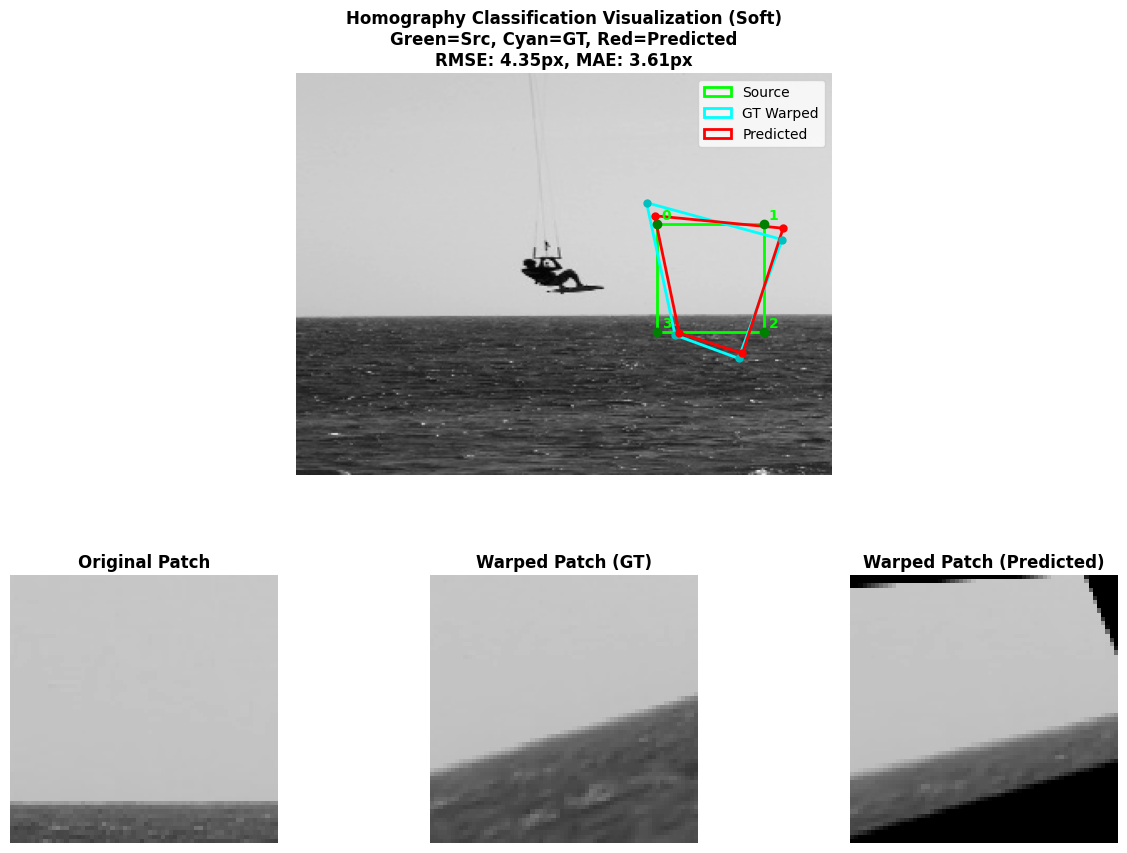

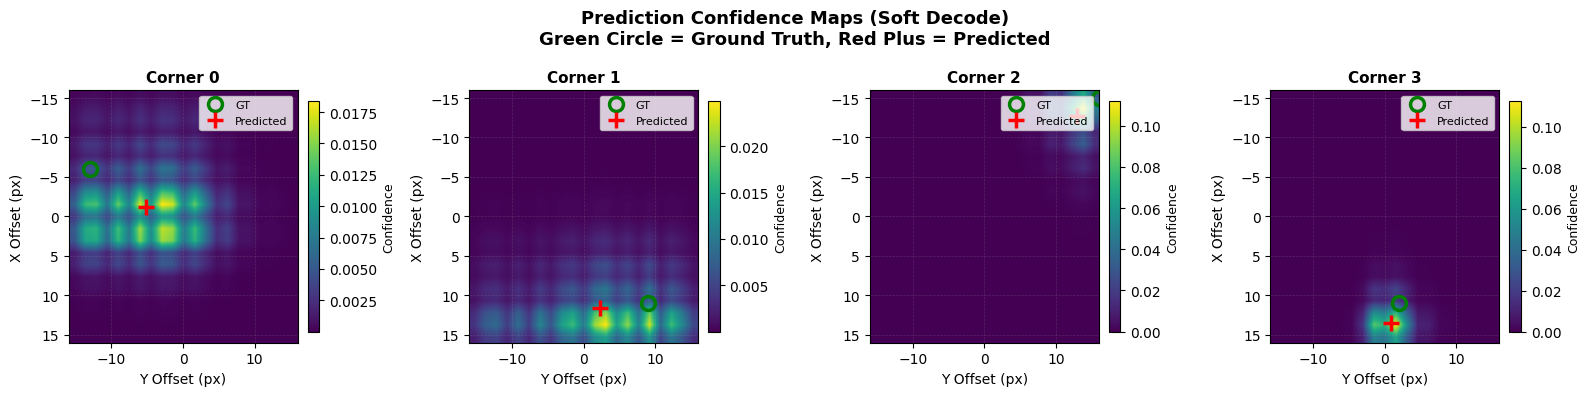

Ground Truth Offsets:
 [[ -6. -13.]
 [ 11.   9.]
 [-15.  16.]
 [ 11.   2.]]
Predicted Offsets:
 [[ -1.18  -5.22]
 [ 11.59   2.23]
 [-12.71  13.  ]
 [ 13.47   0.83]]
Mean Abs Error per corner [px]: [2.541 4.68 ]
Overall Mean Abs Error: 3.611 px


np.float32(3.6107626)

In [30]:
# visualization of classification results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyClassifier(num_classes=21, class_dim=8).to(device)
state = torch.load("Models/Classify/checkpoints_homography_classify_all/checkpoint_epoch_30000.pth")["model_state_dict"]
# state = torch.load("checkpoints_homography_clasify_oneImage/h_clasify_ep50000_I1.pth")
model.load_state_dict(state)
model.eval()

# img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
img = get_random_images(1, image_dir=PREPROCESSED_DIR)[0]
# visualize_classification_result(model=model, image=img, soft_decode=False)
# print("-"*80)
visualize_classification_result(model=model, image=img, soft_decode=True)
# visualize_classification_result_dataloader(
#     model=model,
#     dataloader=dataloader,
#     num_samples=3,
#     soft_decode=True,
#     device=device
# )

Evaluating classical (SIFT): 100%|██████████| 1000/1000 [00:12<00:00, 78.51it/s]



⚠️  Warning: 362/1000 (36.2%) homographies failed

EVALUATION SUMMARY
ocena z Classifier (Soft)    mean:   3.05  std:   2.74
ocena z Regressor (All)      mean:   2.96  std:   2.37
ocena z Classical (SIFT)     mean:  24.30  std:  21.01

✅ Plot saved to eval_results/model_comparison.png


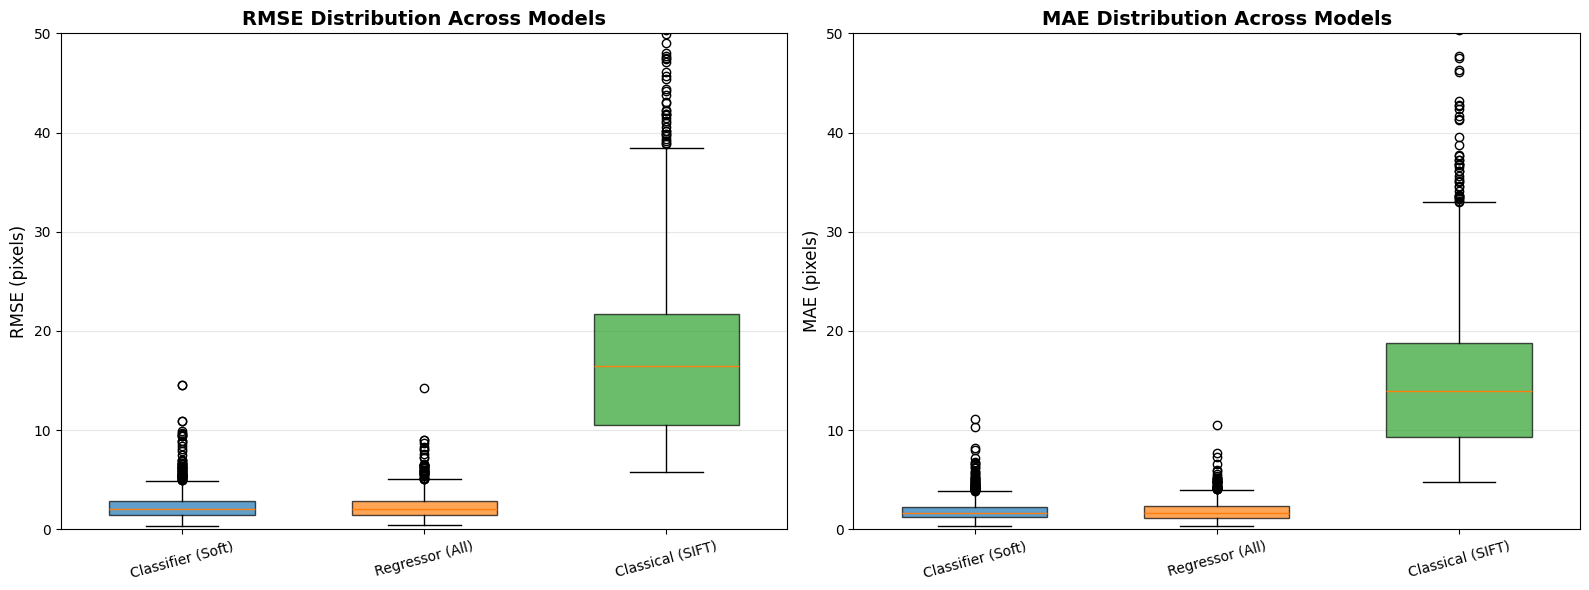


DETAILED STATISTICS

Classifier (Soft):
  RMSE - Mean: 2.4465, Std: 1.5569
  MAE  - Mean: 1.9180, Std: 1.1201
  Corner Errors - Mean: 3.0478
  Percentiles - 50th: 2.3378, 90th: 5.8608, 95th: 7.5721
  Accuracy < 1px: 14.60%
  Accuracy < 2px: 41.50%
  Accuracy < 5px: 85.38%

Regressor (All):
  RMSE - Mean: 2.3387, Std: 1.3177
  MAE  - Mean: 1.8860, Std: 1.0180
  Corner Errors - Mean: 2.9646
  Percentiles - 50th: 2.3608, 90th: 5.7115, 95th: 7.2648
  Accuracy < 1px: 13.53%
  Accuracy < 2px: 41.00%
  Accuracy < 5px: 86.15%

Classical (SIFT):
  RMSE - Mean: 18.9088, Std: 12.5853
  MAE  - Mean: 15.8636, Std: 9.3224
  Corner Errors - Mean: 24.2998
  Percentiles - 50th: 19.1050, 90th: 41.9511, 95th: 54.7835
  Accuracy < 1px: 0.15%
  Accuracy < 2px: 0.43%
  Accuracy < 5px: 3.02%



{'Classifier (Soft)': {'predictions': [{'pred_offsets': array([[-10.767927 ,  11.387426 ],
           [ -8.120937 ,   2.2349002],
           [  7.5078692,  11.787576 ],
           [-11.312503 ,  -3.2440686]], dtype=float32),
    'gt_offsets': array([[ -7.,  10.],
           [ -6.,   4.],
           [  2.,  11.],
           [-14.,   0.]], dtype=float32),
    'src_corners': array([[178., 118.],
           [242., 118.],
           [242., 182.],
           [178., 182.]], dtype=float32),
    'pred_corners': array([[167.23207, 129.38742],
           [233.87906, 120.2349 ],
           [249.50787, 193.78758],
           [166.6875 , 178.75594]], dtype=float32),
    'gt_corners': array([[171., 128.],
           [236., 122.],
           [244., 193.],
           [164., 182.]], dtype=float32)},
   {'pred_offsets': array([[ 13.510006 ,  14.453296 ],
           [ 11.819856 ,  -9.562389 ],
           [-13.927729 ,  -6.1899843],
           [  3.484214 ,  -2.5534256]], dtype=float32),
    'gt_offsets': 

In [33]:
from Evaluation import *
from Generator import get_random_images
from Models import HomographyRegressor, HomographyClassifier
import torch

images = get_random_images(100, "datasets/val2017_preprocessed")
test_samples = generate_test_set(images, samples_per_image=10)

# Compare regression models
regressor_single = HomographyRegressor()
regressor_single.load_state_dict(torch.load(
    "Models/Regressor/checkpoints_homography_regressor_single/h_regressor_single.pth"))

regressor_all = HomographyRegressor()
regressor_all.load_state_dict(torch.load("Models/Regressor/checkpoints_homography_regressor_all/h_regressor_all.pth"))

# results = {
#     'Regressor (Single Image Training)': evaluate_regressor(regressor_single, test_samples),
#     'Regressor (Full Dataset Training)': evaluate_regressor(regressor_all, test_samples)
# }
#
# summarize_and_plot(results, save_dir="eval_results")

# Compare classifiers (soft vs hard decoding)
classifier = HomographyClassifier()
classifier.load_state_dict(torch.load("Models/Classify/checkpoints_homography_classify_all/h_classify_all.pth"))

# results = {
#     'Classifier (soft)': evaluate_classifier(classifier, test_samples, soft_decode=True),
#     'Classifier (hard)': evaluate_classifier(classifier, test_samples, soft_decode=False)
# }
#
# summarize_and_plot(results, save_dir="eval_results")

# Compare classical, regressor and classifier
results = {
    'Classifier (Soft)': evaluate_classifier(classifier, test_samples, soft_decode=True),
    'Regressor (All)': evaluate_regressor(regressor_all, test_samples),
    'Classical (SIFT)': evaluate_classical(test_samples)
}

summarize_and_plot(results, save_dir="eval_results", ylim=50)
